In [4]:
%pwd
%cd PycharmProjects/dqn-anomaly/DQN-Timeseries-Anomaly-Detection/notebooks
%ls -l

[Errno 2] No such file or directory: 'PycharmProjects/dqn-anomaly/DQN-Timeseries-Anomaly-Detection/notebooks'
/home/nj/PycharmProjects/dqn-anomaly/DQN-Timeseries-Anomaly-Detection/notebooks
insgesamt 8420
-rw-rw-r-- 1 nj nj    4566 Nov  6 09:48 BinaryStateDDQN.ipynb
-rw-rw-r-- 1 nj nj 8528338 Nov  5 12:49 memory_sliding_window.obj
-rw-rw-r-- 1 nj nj   26501 Nov  5 11:22 nstep_learning.ipynb
-rw-rw-r-- 1 nj nj   51332 Nov  6 09:48 SlidingWindowStateDDQN.ipynb


In [5]:
import tensorflow as tf
print(tf.__version__)

2.0.0


TimeSeries from: ./Test/SmallData.csv
 Header(labeled):
    value  anomaly
0  12183        0
1  12715        0
2  12736        0 
Header(unlabeled):
    value
0  12183
1  12715
2  12736 
Rows:
 1439
MeanValue:
 11020.08
MaxValue:
 170029
MinValue:
 3594
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                72        
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 50        
Total params: 1,322
Trainable params: 1,322
Non-trainable params: 0
________________________________________________________________

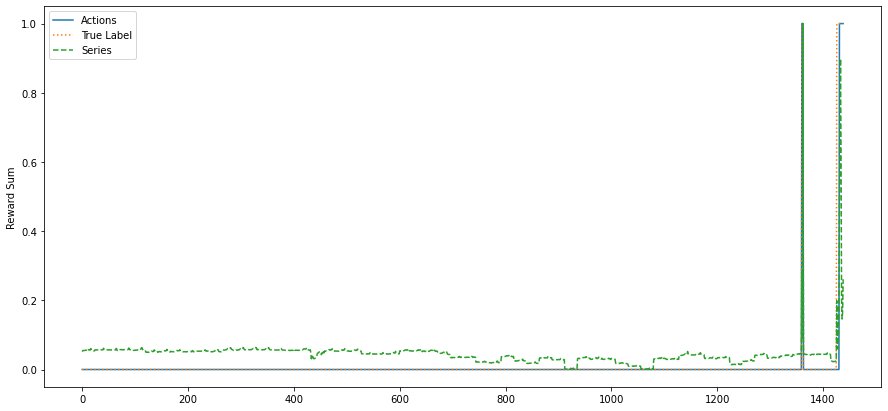

True

In [6]:
from agents.BinaryStateAgent import BinaryStateAgent
from agents.MemoryBuffer import MemoryBuffer
from agents.NeuralNetwork import NeuralNetwork
from agents.Simulator import Simulator
from environment.BinaryStateEnvironment import BinaryStateEnvironment
from environment.Config import ConfigTimeSeries
from environment.BaseEnvironment import TimeSeriesEnvironment

#tf.compat.v1.disable_eager_execution()
config = ConfigTimeSeries(seperator=",", window=1)
env = BinaryStateEnvironment(
    TimeSeriesEnvironment(verbose=True, filename="./Test/SmallData.csv", config=config, window=True))
dqn = NeuralNetwork(input_dim=2,
                    input_neurons=2 + 1).keras_model
agent = BinaryStateAgent(dqn=dqn, memory=MemoryBuffer(max=50000, id="binary_agent"), alpha=0.0001, gamma=0.9, \
                         epsilon=1.0, epsilon_end=0.0, epsilon_decay=0.9, fit_epoch=2, action_space=2, \
                         batch_size=512)
simulation = Simulator(10, agent, env, 5)
agent.memory.init_memory(env=env)
simulation.run()